In [ ]:
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install umap-learn
!pip install transformers torch

In [25]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import pandas as pd

df_latin = pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/latin.csv?raw=true')
df_engineer = pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/engineer.csv?raw=true')

In [3]:
def answer_conc(df):

  df_questions = df[df['ParentId'].isna()]
  df_answers = df[df['ParentId'].notna()]

  df_answers = df_answers.drop(columns=['AcceptedAnswerId','ViewCount','Tags'])

  df_questions = df_questions.merge(df_answers[['Id','Text']], how='left', left_on='AcceptedAnswerId', right_on='Id', suffixes=('', '_Answer'))
  df_questions.rename(columns={'Text_Answer': 'Answer'}, inplace=True)
  df_questions = df_questions.drop(columns='Id_Answer')
  df_answers_reduced = df_answers.loc[df_answers.groupby('ParentId')['Score'].idxmax()]
  df_no_accepted_answer = df_questions[df_questions['AcceptedAnswerId'].isna()]

  for index, row in df_no_accepted_answer.iterrows():
    question_id = row['Id']
    highest_scored_answer = df_answers_reduced[df_answers_reduced['ParentId'] == question_id]
    if not highest_scored_answer.empty:
        df_questions.at[index, 'Answer'] = highest_scored_answer.iloc[0]['Text']
  return df_questions

In [4]:
def process_tags(tags):
    if pd.isna(tags):
      return []
    tags_list = tags.split('|')
    return tags_list[1:-1] if len(tags_list) > 2 else []

In [5]:
def big_clean(df):
  df = df.drop(columns=['LastActivityDate','CreationDate','PostTypeId','OwnerUserId','ContentLicense','CommentCount','AnswerCount'])
  df['Text'] = df['Title'].fillna('') + ' ' + df['Body'].fillna('').str.strip()
  df = df.drop(columns=['Body','Title'])

  questions = answer_conc(df)

  questions.rename(columns={'Text':'Question'},inplace=True)
  questions = questions.drop(columns=['ViewCount','AcceptedAnswerId','ParentId','Score'])

  questions['Tags'] = questions['Tags'].apply(process_tags)

  return questions

In [6]:
latin = big_clean(df_latin)
# ~1000 questions dropped
# latin = latin.dropna(subset=['Answer'])
latin

,Id,Tags,Question,Answer
0,1,"[classical-latin, meaning, vocabulary, conjunc...","Are ""-que"" and ""et"" equivalent? I was taught t...","The way I was taught was that, as a general r..."
1,2,"[contemporary-latin, pronouns, articles, trans...","Why is ""ille"" used in Winnie ille Pu and Hobbi...","It's true that in Classical Latin, ille is a ..."
2,4,"[agreement, predicate, gender, adjective, clas...",What gender should a predicate adjective be to...,Bennett's New Latin Grammar ( this link will ...
3,5,[pronunciation],What effect should a macron have on the sound ...,"In most modern texts, the whole purpose of us..."
4,7,"[etymology, particle, hebrew]","Does ""ad"" have its origin in Hebrew/Semitic la...","No, the similarity is almost certainly accide..."
...,...,...,...,...
6834,23420,[english-to-latin-translation],Four more loaves please This new question: How...,"In Nicholas Oulton's Book II, p.50: ""plures c..."
6835,23425,"[latin-to-english-translation, mathematics]","Mathematical Latin Help So, I'm a PhD student ...","I understand ""ut quotiens sit integer complex..."
6836,23429,"[latin-to-english-translation, translation-check]",Does “interranima” mean “inner soul”? I came a...,"No. Anima is the Latin word for soul, apart f..."
6837,23432,"[diphthong, paleography, ligatures]",What diphthongs are available are Unicode liga...,NaN


In [7]:
engineer = big_clean(df_engineer)
# ~2000 questions dropped
# engineer = engineer.dropna(subset=['Answer'])
engineer

,Id,Tags,Question,Answer
0,1,"[ipsec, ike, vpn]",What's the difference between IKE and ISAKMP? ...,"ISAKMP is part of IKE. (IKE has ISAKMP, SKEME..."
1,3,[qos],Quality of Service based on Layer 7 traffic Ho...,I think this depends heavily on the platform ...
2,4,"[cisco-catalyst, bgp]","Troubleshooting ""Down BGP"" connections Our net...",172259: May 6 14:43:06: %BGP-3-NOTIFICATION:...
3,5,"[ospf, security]",Securing OSPF with only passive interfaces I k...,One issue is that authentication ensures that...
4,6,"[juniper, policing, juniper-ex]",Aggregate Family Rate Limits on Juniper EX Try...,"You are looking for the ""Logical Interface (A..."
...,...,...,...,...
17516,85395,"[switch, network, networking]",Can I configure my Linux box as a virtual netw...,NaN
17517,85396,[tcp],"How does a server handle multiple requests, an...",NaN
17518,85398,"[switch, network, networking, layer3]",Core Switches Redundancy Problem I have networ...,"There are several ways to do this, depending ..."
17519,85401,"[juniper, ipv6, dhcp, dhcpv6, dhcp-snooping]",Juniper and EdgeCore dhcpv6-relay remote-id (o...,NaN


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(latin['Question'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


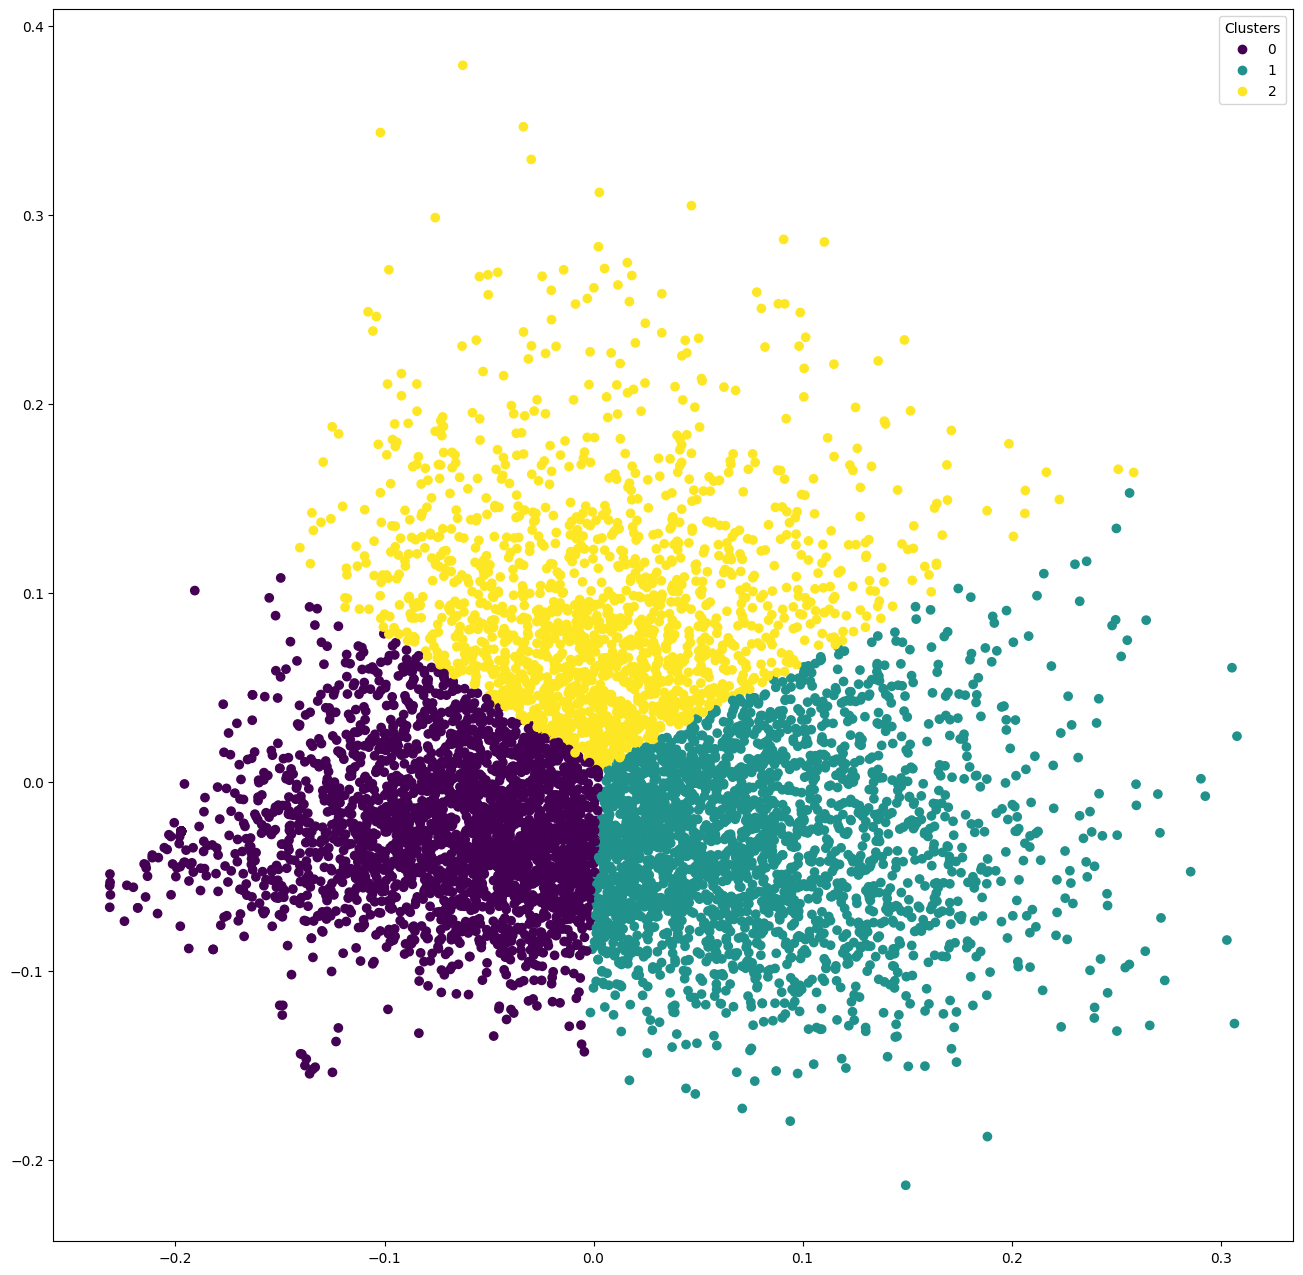

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X_reduced)

plt.figure(figsize=(16, 16))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')

TEXT_SHOW = False

if TEXT_SHOW:
  for i, txt in enumerate(latin['Question']):
      plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8)


plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [ ]:
tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(X.toarray())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


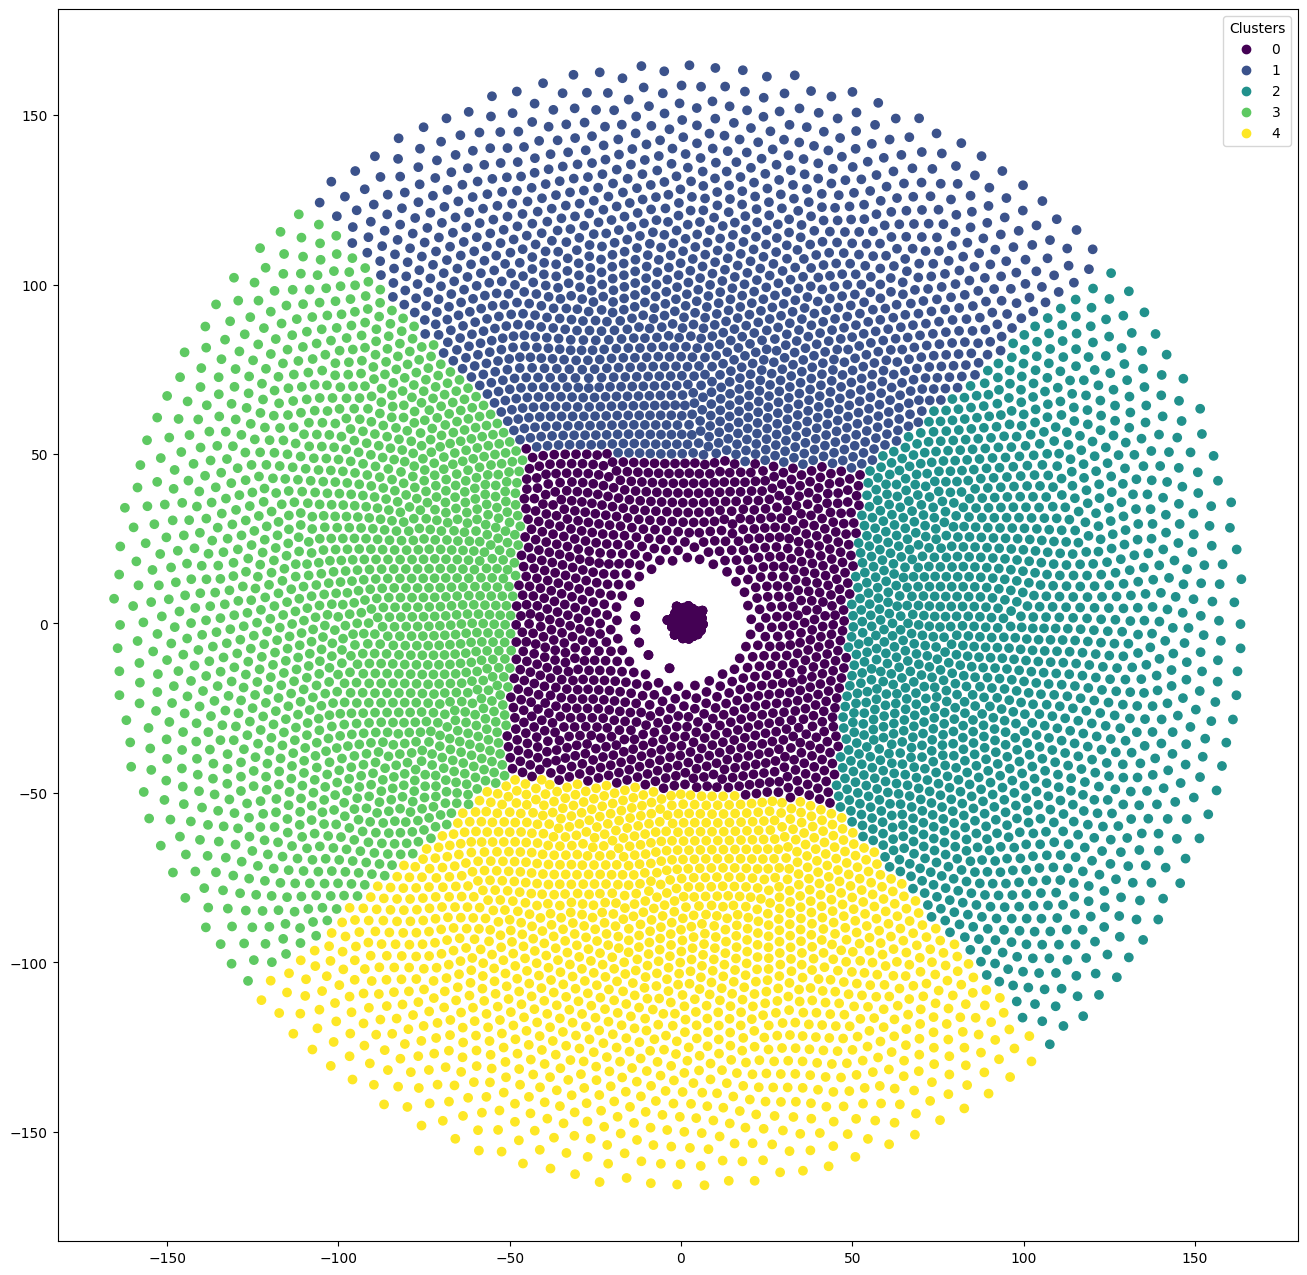

In [18]:
clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X_reduced)

plt.figure(figsize=(16, 16))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')

TEXT_SHOW = False

if TEXT_SHOW:
  for i, txt in enumerate(latin['Question']):
      plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8)


plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [21]:
import umap

umap_reducer = umap.UMAP(n_components=2, random_state=0)
X_reduced = umap_reducer.fit_transform(X.toarray())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


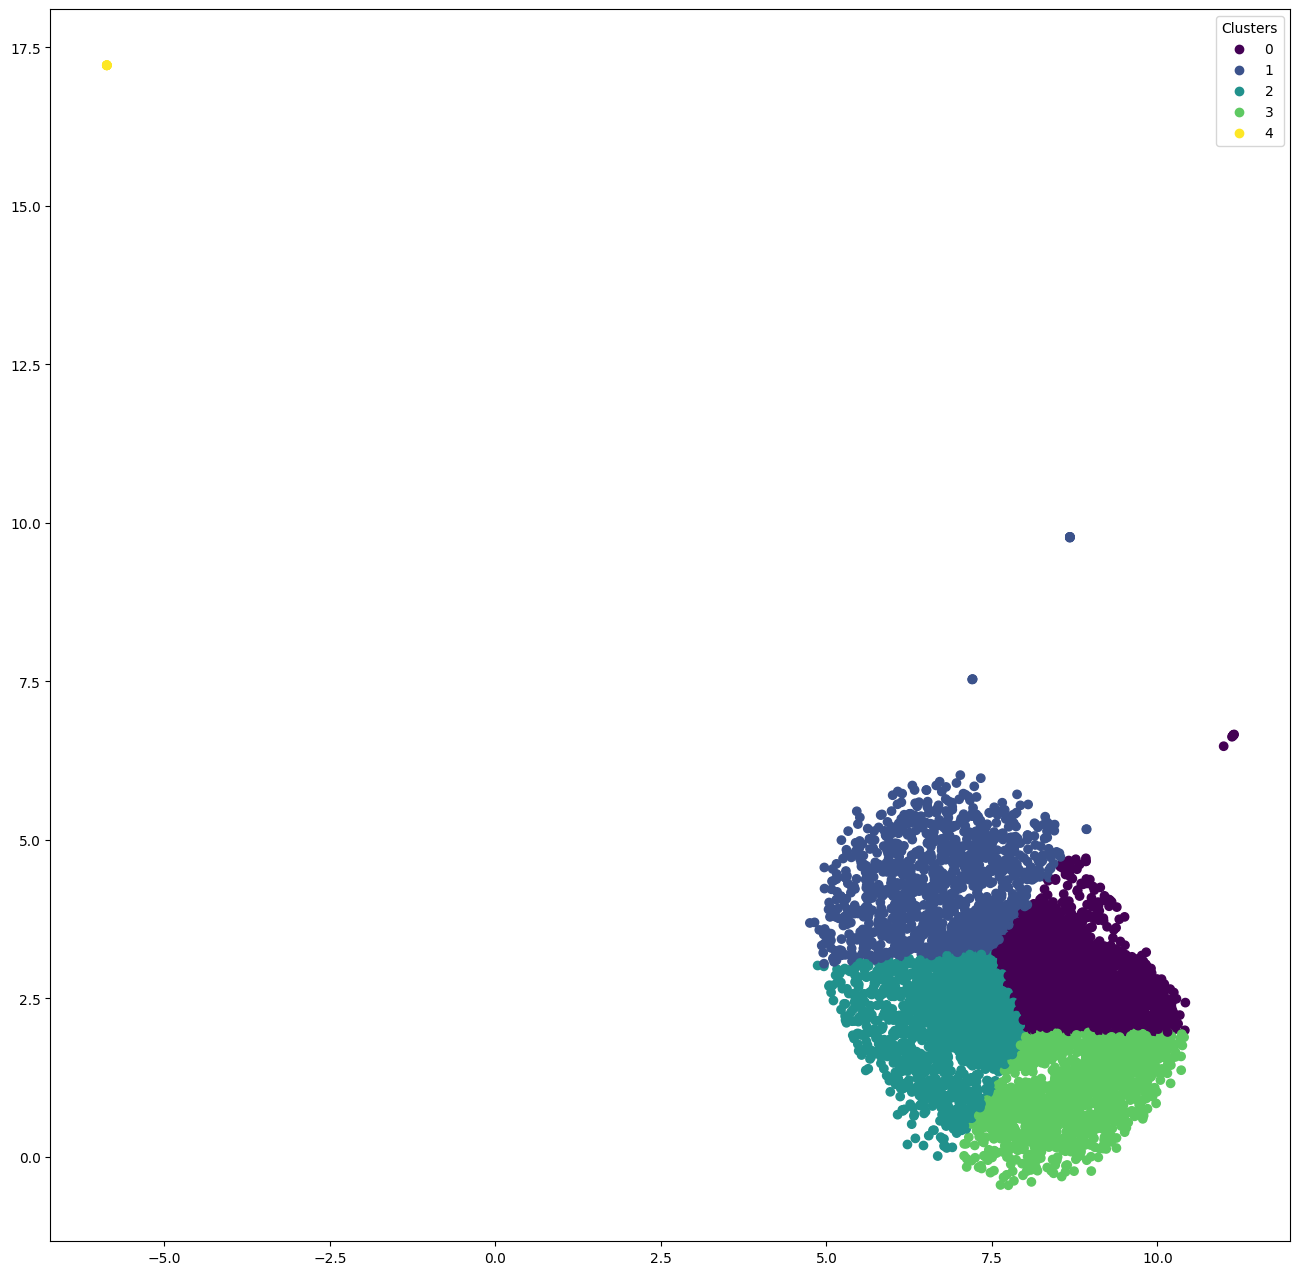

In [24]:
clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X_reduced)

plt.figure(figsize=(16, 16))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')

TEXT_SHOW = False

if TEXT_SHOW:
  for i, txt in enumerate(latin['Question']):
      plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8)


plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

KeyboardInterrupt: 

In [ ]:
# stuff to try OHE/BOW
# különböző távolsági metrikák

# 2d ábrázolás - WIP

# BERT változatok - lassú, nagyon

# cluster és tag korreláció